<a href="https://colab.research.google.com/github/jmohsbeck1/jpmc_mle/blob/final_project/DataDazzlers_DineOracle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [1]:
import os
import warnings
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

In [18]:
#Dataframe and numerical library
import pandas as pd 
import numpy as np

#Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# SQLite
import sqlite3

# geopandas for latitude and longitude plotting
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

#Machine Learming Model
#Metrics
from sklearn.metrics import mutual_info_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Linear Model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

#Ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Others
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

#Hyper parameter
from sklearn import neighbors, datasets, model_selection

# Data Import

In [3]:
#STEP 1: Import large dataset using opendatasets
if not os.path.exists('yelp-dataset'):
  print("Loading Keys")
  kaggle_key = 'ravikiranbutti'
  kaggle_value = '117268fa41345f39e5baeda66733a0c7'
  os.environ['KAGGLE_USERNAME'] = kaggle_key
  os.environ['KAGGLE_KEY'] = kaggle_value
  !mkdir -p /root/.kaggle
  with open('/root/.kaggle/kaggle.json', 'w') as kaggle_file:
    kaggle_file.write('{"username":"' + kaggle_key + '","key":"' + kaggle_value + '"}')

  print("Loading Data")
  !pip install kaggle
  !kaggle datasets download yelp-dataset/yelp-dataset
  !unzip yelp-dataset.zip -d 'yelp-dataset'
  !rm yelp-dataset.zip

In [4]:
#STEP 2: Load Business using chunk processing
business_chunks = pd.read_json("yelp-dataset/yelp_academic_dataset_business.json", lines=True, chunksize=10000)
business = pd.concat(business_chunks) 

In [5]:
#Print information
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [6]:
#STEP 3: Load Review using chunk processing and filtering unwanted colums
review = []
review_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelp-dataset/yelp_academic_dataset_review.json", "r") as f:
    review_chunks = pd.read_json(f, orient="records", lines=True, dtype=review_dtypes, chunksize=1000)
        
    for review_chunk in review_chunks:
        reduced_review_chunk = review_chunk.drop(columns=['review_id', 'useful','funny','cool', 'text','date'])
        review.append(reduced_review_chunk)
    
review = pd.concat(review, ignore_index=True)

In [7]:
#Print information
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      object 
 1   business_id  object 
 2   stars        float16
dtypes: float16(1), object(2)
memory usage: 120.0+ MB


In [8]:
#STEP 4: Load User using chunk processing and filtering unwanted colums
user = []
with open("yelp-dataset/yelp_academic_dataset_user.json", "r") as f:
    user_chunks = pd.read_json(f, orient="records", lines=True, chunksize=1000)
        
    for user_chunk in user_chunks:
        reduced_user_chunk = user_chunk.drop(columns=['name', 'useful','funny','cool', 'elite','friends'])
        user.append(reduced_user_chunk)
    
user = pd.concat(user, ignore_index=True)

In [9]:
#Print information
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   review_count        int64  
 2   yelping_since       object 
 3   fans                int64  
 4   average_stars       float64
 5   compliment_hot      int64  
 6   compliment_more     int64  
 7   compliment_profile  int64  
 8   compliment_cute     int64  
 9   compliment_list     int64  
 10  compliment_note     int64  
 11  compliment_plain    int64  
 12  compliment_cool     int64  
 13  compliment_funny    int64  
 14  compliment_writer   int64  
 15  compliment_photos   int64  
dtypes: float64(1), int64(13), object(2)
memory usage: 242.7+ MB


In [10]:
business.shape

(150346, 14)

In [11]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [12]:
categorical_features=['business_id', 'name', 'address', 'city', 'state', 'attributes', 'categories', 'hours' 'postal_code']
numeric_features=['latitude', 'longitude', 'stars', 'review_count']
target_feature=['is_open']

In [19]:
# coverting csv to geopandas dataframe
geometry = [Point(xy) for xy in zip(business['longitude'], business['latitude'])]
gdf = GeoDataFrame(business, geometry = geometry)


<AxesSubplot: >

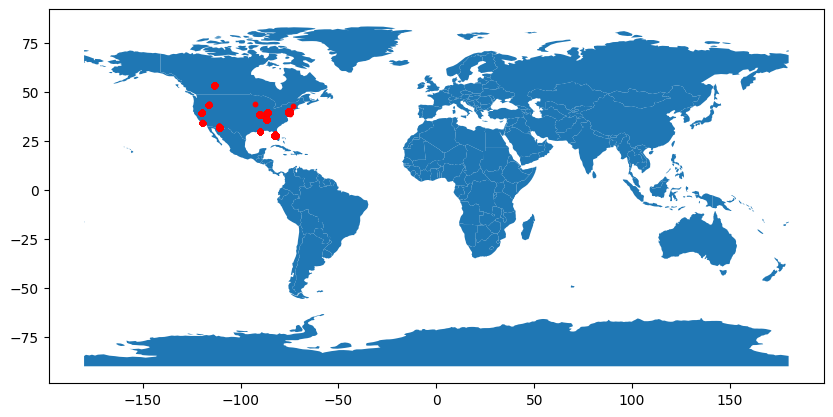

In [20]:
# plotting naturalearth_lowres map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax = world.plot(figsize = (10, 10)), color = 'red', markersize = 10)


# Data Cleanup